In [1]:
import warnings
warnings.simplefilter(action='ignore')
from focal_loss import SparseCategoricalFocalLoss
import pandas as pd
import tensorflow as tf
import glob
import math
import matplotlib.pyplot as plt
import json
import numpy as np
import random
from tqdm import tqdm
import tensorflow_addons as tfa
import os
import tensorflow_io as tfio

In [2]:
def seed_it_all(seed=7):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_it_all()

In [3]:
ROWS_PER_FRAME = 543
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

#test_data  = load_relevant_data_subset('train_landmark_files/16069/100015657.parquet')

In [4]:
LIP = [
            61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
            291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
            78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
            95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]


In [172]:
class CFG:
    left_ROWS_per_frame = 21
    sequence_length = 20
    batch_size = 32
    face_ROWS_per_frame = 468
    lip_ROWS_per_frame = 40

labels  = json.load(open('sign_to_prediction_index_map.json','r'))
complete_df = pd.read_csv('extended_train.csv')
complete_df = complete_df[complete_df['participant_id']!='37055']
from sklearn.model_selection import train_test_split
y = complete_df['sign']
train_df2, test_df2 = train_test_split(complete_df, test_size=0.2,stratify=y)

In [6]:
def build_loader(with_labels=True):
    def load_video(video_path):
        #print('herer')
        video_df = tfio.IODataset.from_parquet(video_path)
        #video_df = pd.read_parquet(video_path, engine='pyarrow')
        #video_df.fillna(0,inplace=True)
        left_df = video_df[video_df.type=='left_hand']
        left_values = left_df[['x','y','z']].values
        left_values = left_values.reshape(-1,CFG.left_ROWS_per_frame,3)
        left_hand_array =  tf.image.resize(left_values, (CFG.sequence_length, CFG.left_ROWS_per_frame))
        right_df = video_df[video_df.type=='right_hand']
        right_values = right_df[['x','y','z']].values
        right_values = right_values.reshape(-1,CFG.left_ROWS_per_frame,3)
        right_hand_array =  tf.image.resize(right_values, (CFG.sequence_length, CFG.left_ROWS_per_frame))
        return [left_hand_array, right_hand_array]
    
    def load_video_with_labels(path, label):
        return load_video(path), labels[label]
    
    return load_video_with_labels if with_labels else load_video

In [7]:
class CustomData(tf.keras.utils.Sequence):
    def __init__(self,df,num_frames=20,batch_size=8,shuffle=True,\
                 labels_path='sign_to_prediction_index_map.json'):
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_frames = num_frames
        self.labels  = json.load(open('sign_to_prediction_index_map.json','r'))
        self.on_epoch_end()
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self,index):
        batches = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        combined = np.zeros(shape=(self.batch_size,self.num_frames,\
                                        CFG.left_ROWS_per_frame+CFG.lip_ROWS_per_frame,3))
        labels = []
        for i,row_val in enumerate(batches):
            row = self.df.iloc[row_val]
            left_hand,lip = self.load_video(row['path'])
            combined[i,:,:21,:] = left_hand
            combined[i,:,21:,:] = lip
            labels.append(self.labels[row['sign']])
        return combined,np.asarray(labels)
            
    def load_video(self,video_path):
        video_df = pd.read_parquet(video_path, engine='pyarrow')
        #video_df.dropna(inplace=True)
        
        if video_df[video_df['type']=='left_hand']['x'].isna().mean() <= \
      video_df[video_df['type']=='right_hand']['x'].isna().mean():
            left_df = video_df[video_df.type=='left_hand']
            left_df.dropna(inplace=True)
            if len(left_df) != 0:
                left_values = left_df[['x','y','z']].values
                left_values = left_values.reshape(-1,CFG.left_ROWS_per_frame,3)
                left_hand_array =  tf.image.resize(left_values, (CFG.sequence_length, CFG.left_ROWS_per_frame))
            else:
                left_hand_array = tf.zeros(shape=(CFG.sequence_length, CFG.left_ROWS_per_frame,2),dtype=tf.float32)
        else:
            left_df = video_df[video_df.type=='right_hand']
            left_df.dropna(inplace=True)
            if len(left_df) != 0:
                left_values = left_df[['x','y','z']].values
                left_values = left_values.reshape(-1,CFG.left_ROWS_per_frame,3)
                left_values[:,:,:1] = np.max(left_values[:,:,:1]) - left_values[:,:,:1] 
                left_hand_array =  tf.image.resize(left_values, (CFG.sequence_length, CFG.left_ROWS_per_frame))
            else:
                left_hand_array = tf.zeros(shape=(CFG.sequence_length, CFG.left_ROWS_per_frame,3),dtype=tf.float32)
        
        face_df = video_df[video_df.type=='face']
        face_df.dropna(inplace=True)
        face_df = face_df[['x','y','z']].values
        face_df = face_df.reshape(-1,CFG.face_ROWS_per_frame,3)
        lip_values = face_df[:,LIP,:]
        if len(lip_values) != 0:
            lip_values_array =  tf.image.resize(lip_values, (CFG.sequence_length, CFG.lip_ROWS_per_frame))
        else:
            lip_values_array = tf.zeros(shape=(CFG.sequence_length, CFG.lip_ROWS_per_frame,3),dtype=tf.float32)
        
        return left_hand_array,lip_values_array
    
    def __len__(self):
        return len(self.df)//self.batch_size

In [8]:
train_datagen = CustomData(train_df,num_frames=CFG.sequence_length,batch_size=256)
test_datagen = CustomData(test_df,num_frames=CFG.sequence_length,batch_size=256)

In [9]:
all_data_x = []
all_data_y = []
for i in range(len(train_datagen)):
    x,y = train_datagen[i]
    all_data_x.extend(x)
    all_data_y.extend(y)

KeyboardInterrupt: 

In [12]:
np.save('X_train_20x61_left.npy', np.asarray(all_data_x))
np.save('y_train_20x61_left.npy', np.asarray(all_data_y))

In [10]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 384

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

In [11]:
def get_temporal_encoding(seq_length, d_model):
    # Generate additional temporal embedding
    temp_enc = np.zeros((seq_length, d_model))
    for i in range(seq_length):
        temp_enc[i, :] = i / tf.cast(seq_length, dtype=tf.float32)
    temp_enc = temp_enc[tf.newaxis, ...]
    return tf.cast(temp_enc, dtype=tf.float32)

In [202]:
def transformer_architecture():
    # Define the hyperparameters
    num_layers = 4
    d_model = 122
    num_heads = 4
    dff = 256
    dropout_rate = 0.2
    lips_input_shape = (20,40,2)
    hands_input_shape = (20,21,2)
    # Flatten the last two dimensions
    frames = tf.keras.layers.Input([20, 61, 3], dtype=tf.float32, name='frames')
    
    """
        left_hand: 468:489
        pose: 489:522
        right_hand: 522:543
    """
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,20, 61, 2])
    # LIPS
    lips = tf.slice(x, [0,0,20,0], [-1,20, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIPS_MEAN) / LIPS_STD,
        )
    lips_inputs = tf.reshape(lips, [-1, 20, 40*2])
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,0,0], [-1,20, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    hands_inputs = tf.reshape(left_hand, [-1, 20, 21*2])
    print(lips_inputs.shape,hands_inputs.shape)
    #lips_inputs = tf.keras.layers.Input(shape=lips_input_shape)
    #hands_inputs = tf.keras.layers.Input(shape=hands_input_shape)
    x1 = tf.keras.layers.Reshape((lips_input_shape[0], lips_input_shape[1]*lips_input_shape[2]))(lips_inputs)
    x2 = tf.keras.layers.Reshape((hands_input_shape[0], hands_input_shape[1]*hands_input_shape[2]))(hands_inputs)
    # Positional encoding
    x1 = x1 + positional_encoding(20, 80)
    x2 = x2 + positional_encoding(20, 42)
    #print(x1.shape)
    #pos_enc1 = tf.keras.layers.Embedding(lips_input_shape[1], 80)(tf.range(lips_input_shape[1]))
    #print(pos_enc1.shape)
    #pos_enc1 = tf.repeat(pos_enc1, 20, axis=0)
    #x1 = x1 + pos_enc1
    
#     pos_enc2 = tf.keras.layers.Embedding(hands_input_shape[1], d_model)(tf.range(hands_input_shape[1]))
#     pos_enc2 = tf.repeat(pos_enc2, hands_input_shape[0], axis=0)
#     x2 = x2 + pos_enc2
    print(x1.shape,x2.shape)
    x = tf.concat([x1, x2], axis=-1)
    # Transformer encoder
    print(x.shape)
    for i in range(num_layers):
        # Multi-head attention
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model)(x, x)
        attention_output = tf.keras.layers.Dropout(dropout_rate)(attention_output)
        x = tf.keras.layers.LayerNormalization(
            epsilon=1e-6)(x + attention_output)
        # Feedforward
        ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
        ])
        ffn_output = ffn(x)
        ffn_output = tf.keras.layers.Dropout(dropout_rate)(ffn_output)
        x = tf.keras.layers.LayerNormalization(
            epsilon=1e-6)(x + ffn_output)

    # Output layer
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    outputs = x
    # Define the model
    model = tf.keras.Model(inputs=frames, outputs=outputs)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    # Print the model summary
    
    model.summary()
    model.compile(loss=loss, optimizer=optimizer, metrics='accuracy')
    return model

In [203]:
model = transformer_architecture()

(None, 20, 80) (None, 20, 42)
(None, 20, 80) (None, 20, 42)
(None, 20, 122)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 20, 61, 3)]  0           []                               
                                                                                                  
 tf.slice_3 (TFOpLambda)        (None, 20, 61, 2)    0           ['frames[0][0]']                 
                                                                                                  
 tf.slice_4 (TFOpLambda)        (None, 20, 40, 2)    0           ['tf.slice_3[0][0]']             
                                                                                                  
 tf.slice_5 (TFOpLambda)        (None, 20, 21, 2)    0           ['tf.slice_3[0][0]']             
                

 dropout_27 (Dropout)           (None, 20, 122)      0           ['sequential_13[0][0]']          
                                                                                                  
 tf.__operators__.add_31 (TFOpL  (None, 20, 122)     0           ['layer_normalization_26[0][0]', 
 ambda)                                                           'dropout_27[0][0]']             
                                                                                                  
 layer_normalization_27 (LayerN  (None, 20, 122)     244         ['tf.__operators__.add_31[0][0]']
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_14 (Multi  (None, 20, 122)     239730      ['layer_normalization_27[0][0]', 
 HeadAttention)                                                   'layer_normalization_27[0][0]'] 
          

In [191]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

In [192]:
# If True, processing data from scratch
# If False, loads preprocessed data
PREPROCESS_DATA = False
TRAIN_MODEL = True
# True: use 10% of participants as validation set
# False: use all data for training -> gives better LB result
USE_VAL = False
N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 42
NUM_CLASSES = 250
INPUT_SIZE = 64
BATCH_ALL_SIGNS_N = 4
BATCH_SIZE = 256
N_EPOCHS = 100
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
MASK_VAL = 4237
N_COLS = 61

In [193]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIPS_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size
# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

# HAND_IDXS: 21, N_COLS: 66
LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61


In [194]:
# Load Data
ROOT_DIR = '/home/sign_language/'
if USE_VAL:
    # Load Train
    X_train = np.load(f'{ROOT_DIR}/X_train.npy')
    y_train = np.load(f'{ROOT_DIR}/y_train.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_TRAIN.npy')
    # Load Val
    X_val = np.load(f'{ROOT_DIR}/X_val.npy')
    y_val = np.load(f'{ROOT_DIR}/y_val.npy')
    NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_VAL.npy')
    # Define validation Data
    validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)
else:
    X_train = np.load(f'{ROOT_DIR}/X.npy')
    y_train = np.load(f'{ROOT_DIR}/y.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS.npy')
    validation_data = None

# Train 
# Val
if USE_VAL:
    print_shape_dtype([X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL], ['X_val', 'y_val', 'NON_EMPTY_FRAME_IDXS_VAL'])
# Sanity Check
print(f'# NaN Values X_train: {np.isnan(X_train).sum()}')

# NaN Values X_train: 0


100%|██████████| 40/40 [00:01<00:00, 32.27it/s]


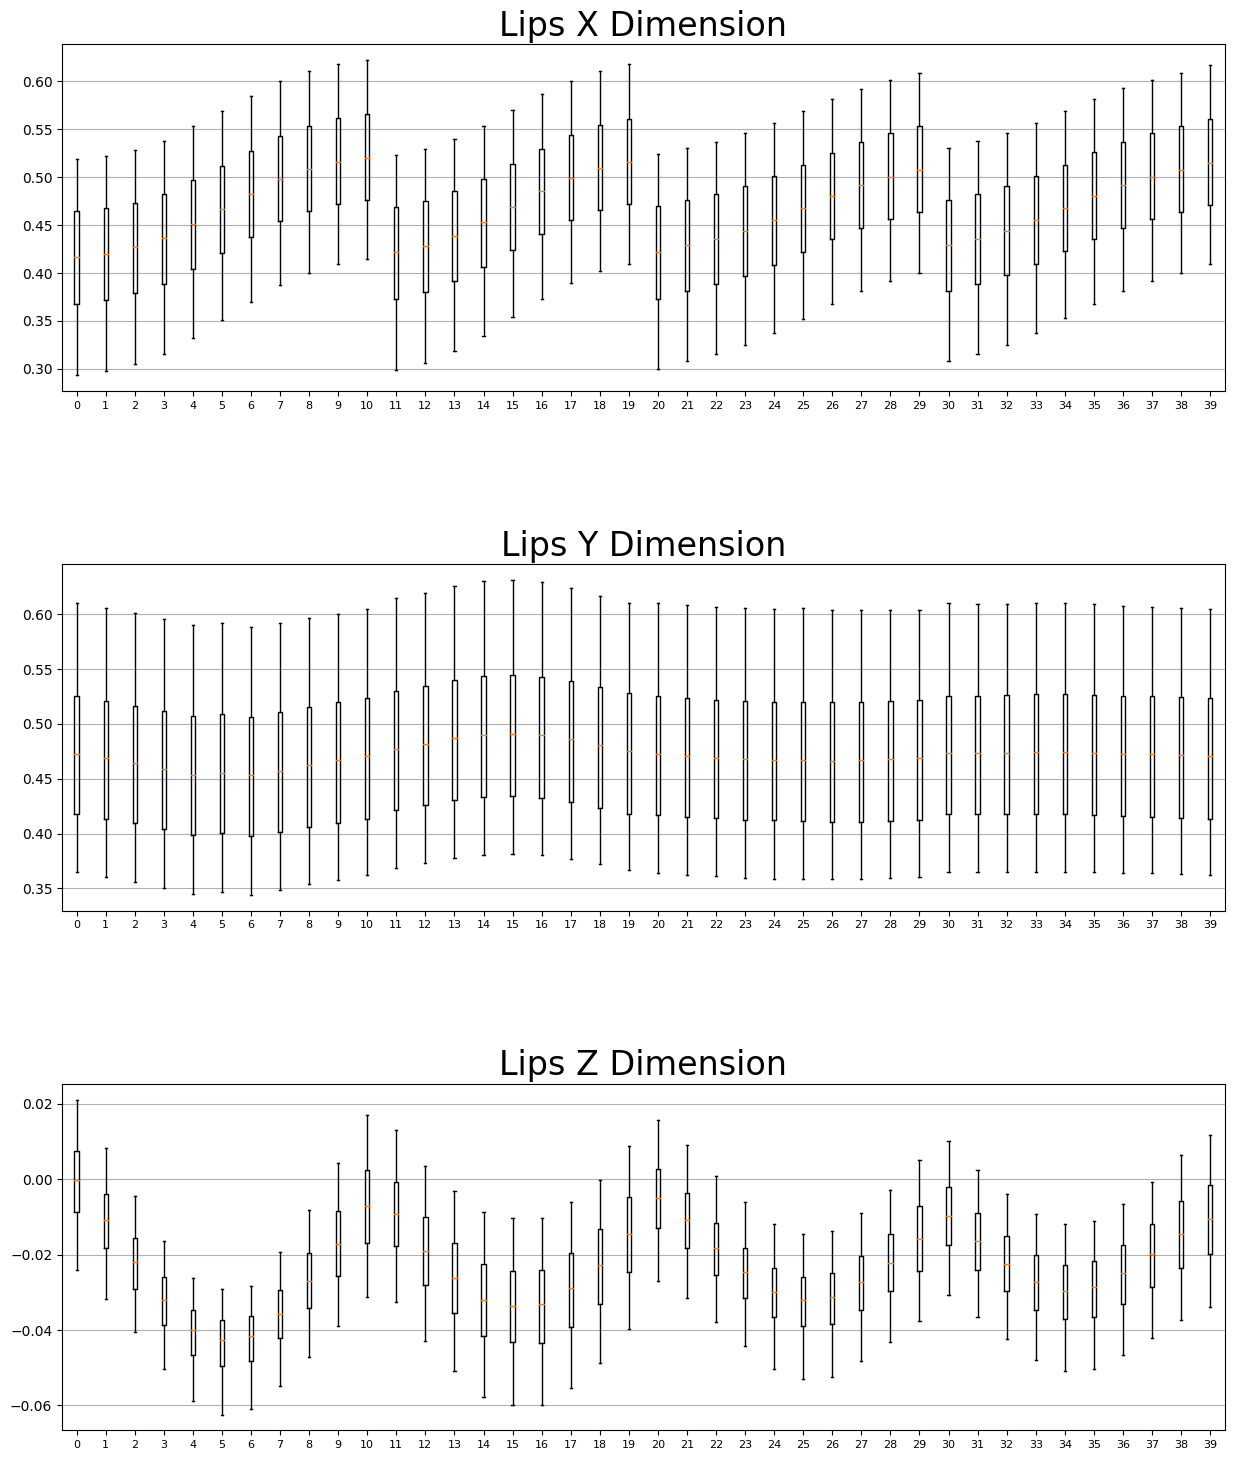

In [195]:
def get_lips_mean_std():
    # LIPS
    LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LIPS_MEAN_X[col] = v.mean()
                LIPS_STD_X[col] = v.std()
            if dim == 1: # Y
                LIPS_MEAN_Y[col] = v.mean()
                LIPS_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
    LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T
    
    return LIPS_MEAN, LIPS_STD

LIPS_MEAN, LIPS_STD = get_lips_mean_std()

100%|██████████| 21/21 [00:00<00:00, 39.21it/s]


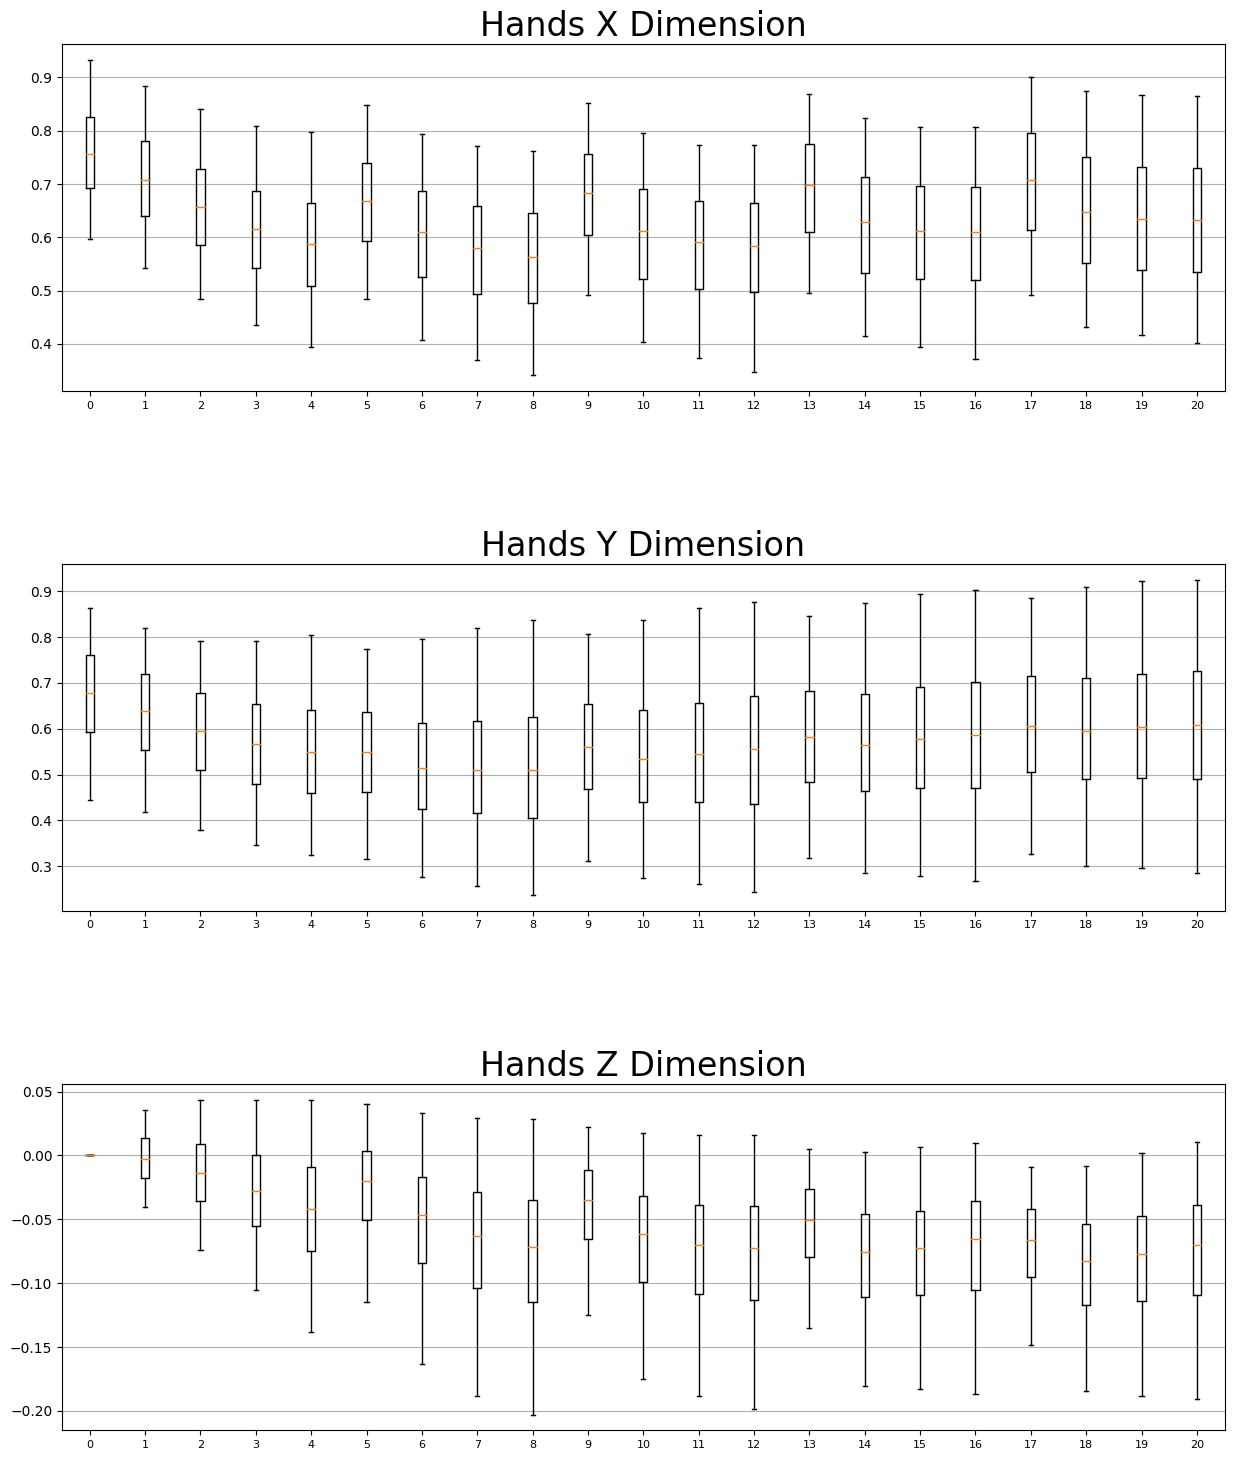

In [196]:
def get_left_right_hand_mean_std():
    # LEFT HAND
    LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_HAND_IDXS], [2,3,0,1]).reshape([LEFT_HAND_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
    LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
    
    return LEFT_HANDS_MEAN, LEFT_HANDS_STD

LEFT_HANDS_MEAN, LEFT_HANDS_STD = get_left_right_hand_mean_std()

In [197]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

In [198]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

In [199]:
# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)


In [200]:
x_train = np.load('X_train_20x61_left.npy')
y_train = np.load('y_train_20x61_left.npy')
x_test = np.load('X_test_20x61_left.npy')
y_test = np.load('y_test_20x61_left.npy')

In [204]:
tf.keras.backend.clear_session()

# Get new fresh model
model = transformer_architecture()
file_name = 'models/042223_20_52.h5'
#model = tf.keras.models.load_model('models/041423_21_02.h5')

# Sanity Check
model.summary()

# Actual Training
history = model.fit(
        x=x_train,
        y=y_train,
        epochs=100,
        # Only used for validation data since training data is a generator
        batch_size=256,
        validation_data=(x_test,y_test),
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(
            file_name,
            save_weights_only = False,
            save_best_only=True, 
            monitor="val_accuracy",
            mode="max",
            verbose = 1),
            lr_callback,
            WeightDecayCallback(),
        ],
        verbose = 1,
    )

(None, 20, 80) (None, 20, 42)
(None, 20, 80) (None, 20, 42)
(None, 20, 122)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 20, 61, 3)]  0           []                               
                                                                                                  
 tf.slice (TFOpLambda)          (None, 20, 61, 2)    0           ['frames[0][0]']                 
                                                                                                  
 tf.slice_1 (TFOpLambda)        (None, 20, 40, 2)    0           ['tf.slice[0][0]']               
                                                                                                  
 tf.slice_2 (TFOpLambda)        (None, 20, 21, 2)    0           ['tf.slice[0][0]']               
                  

                                                                                                  
 tf.__operators__.add_5 (TFOpLa  (None, 20, 122)     0           ['layer_normalization_2[0][0]',  
 mbda)                                                            'dropout_3[0][0]']              
                                                                                                  
 layer_normalization_3 (LayerNo  (None, 20, 122)     244         ['tf.__operators__.add_5[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_2 (MultiH  (None, 20, 122)     239730      ['layer_normalization_3[0][0]',  
 eadAttention)                                                    'layer_normalization_3[0][0]']  
                                                                                                  
 dropout_4

                                                                  'tf.math.truediv[0][0]']        
                                                                                                  
 tf.where_1 (TFOpLambda)        (None, 20, 21, 2)    0           ['tf.math.equal_1[0][0]',        
                                                                  'tf.math.truediv_1[0][0]']      
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 20, 80)       0           ['tf.where[0][0]']               
                                                                                                  
 tf.reshape_1 (TFOpLambda)      (None, 20, 42)       0           ['tf.where_1[0][0]']             
                                                                                                  
 reshape (Reshape)              (None, 20, 80)       0           ['tf.reshape[0][0]']             
          

 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_3 (MultiH  (None, 20, 122)     239730      ['layer_normalization_5[0][0]',  
 eadAttention)                                                    'layer_normalization_5[0][0]']  
                                                                                                  
 dropout_6 (Dropout)            (None, 20, 122)      0           ['multi_head_attention_3[0][0]'] 
                                                                                                  
 tf.__operators__.add_8 (TFOpLa  (None, 20, 122)     0           ['layer_normalization_5[0][0]',  
 mbda)                                                            'dropout_6[0][0]']              
                                                                                                  
 layer_nor

293/295 [============================>.] - ETA: 0s - loss: 1.1884 - accuracy: 0.6918
Epoch 11: val_accuracy improved from 0.66337 to 0.66931, saving model to models/042223_20_52.h5
295/295 [==============================] - 5s 17ms/step - loss: 1.1880 - accuracy: 0.6918 - val_loss: 1.3392 - val_accuracy: 0.6693 - lr: 9.7553e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0009704403844771128.
learning rate: 9.70e-04, weight decay: 4.85e-05
Epoch 12/100
295/295 [==============================] - ETA: 0s - loss: 1.1326 - accuracy: 0.7045
Epoch 12: val_accuracy improved from 0.66931 to 0.67755, saving model to models/042223_20_52.h5
295/295 [==============================] - 5s 17ms/step - loss: 1.1326 - accuracy: 0.7045 - val_loss: 1.3167 - val_accuracy: 0.6775 - lr: 9.7044e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0009648882429441257.
learning rate: 9.65e-04, weight decay: 4.82e-05
Epoch 13/100
294/295 [============================>.] - ETA: 0s - los

293/295 [============================>.] - ETA: 0s - loss: 0.6235 - accuracy: 0.8271
Epoch 29: val_accuracy improved from 0.73721 to 0.73935, saving model to models/042223_20_52.h5
295/295 [==============================] - 5s 17ms/step - loss: 0.6243 - accuracy: 0.8269 - val_loss: 1.1498 - val_accuracy: 0.7394 - lr: 8.1871e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.0008064535268264883.
learning rate: 8.06e-04, weight decay: 4.03e-05
Epoch 30/100
293/295 [============================>.] - ETA: 0s - loss: 0.6105 - accuracy: 0.8303
Epoch 30: val_accuracy did not improve from 0.73935
295/295 [==============================] - 5s 17ms/step - loss: 0.6104 - accuracy: 0.8302 - val_loss: 1.1828 - val_accuracy: 0.7390 - lr: 8.0645e-04

Epoch 31: LearningRateScheduler setting learning rate to 0.0007938926261462366.
learning rate: 7.94e-04, weight decay: 3.97e-05
Epoch 31/100
293/295 [============================>.] - ETA: 0s - loss: 0.5911 - accuracy: 0.8358
Epoch 31: val_a

295/295 [==============================] - 5s 17ms/step - loss: 0.3186 - accuracy: 0.9080 - val_loss: 1.2622 - val_accuracy: 0.7503 - lr: 5.6267e-04

Epoch 48: LearningRateScheduler setting learning rate to 0.0005470541566592572.
learning rate: 5.47e-04, weight decay: 2.74e-05
Epoch 48/100
295/295 [==============================] - ETA: 0s - loss: 0.3071 - accuracy: 0.9114
Epoch 48: val_accuracy did not improve from 0.75974
295/295 [==============================] - 5s 16ms/step - loss: 0.3071 - accuracy: 0.9114 - val_loss: 1.2660 - val_accuracy: 0.7540 - lr: 5.4705e-04

Epoch 49: LearningRateScheduler setting learning rate to 0.0005313952597646568.
learning rate: 5.31e-04, weight decay: 2.66e-05
Epoch 49/100
295/295 [==============================] - ETA: 0s - loss: 0.2894 - accuracy: 0.9172
Epoch 49: val_accuracy did not improve from 0.75974
295/295 [==============================] - 5s 17ms/step - loss: 0.2894 - accuracy: 0.9172 - val_loss: 1.2426 - val_accuracy: 0.7595 - lr: 5.3140

295/295 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9705
Epoch 66: val_accuracy did not improve from 0.77221
295/295 [==============================] - 5s 17ms/step - loss: 0.1159 - accuracy: 0.9705 - val_loss: 1.3484 - val_accuracy: 0.7708 - lr: 2.7300e-04

Epoch 67: LearningRateScheduler setting learning rate to 0.0002591231629491423.
learning rate: 2.59e-04, weight decay: 1.30e-05
Epoch 67/100
294/295 [============================>.] - ETA: 0s - loss: 0.1098 - accuracy: 0.9720
Epoch 67: val_accuracy did not improve from 0.77221
295/295 [==============================] - 5s 16ms/step - loss: 0.1099 - accuracy: 0.9720 - val_loss: 1.3555 - val_accuracy: 0.7684 - lr: 2.5912e-04

Epoch 68: LearningRateScheduler setting learning rate to 0.00024547929212481435.
learning rate: 2.45e-04, weight decay: 1.23e-05
Epoch 68/100
294/295 [============================>.] - ETA: 0s - loss: 0.1022 - accuracy: 0.9743
Epoch 68: val_accuracy improved from 0.77221 to 0.77333, s

295/295 [==============================] - 5s 17ms/step - loss: 0.0368 - accuracy: 0.9942 - val_loss: 1.3948 - val_accuracy: 0.7806 - lr: 6.9629e-05

Epoch 85: LearningRateScheduler setting learning rate to 6.184665997806832e-05.
learning rate: 6.18e-05, weight decay: 3.09e-06
Epoch 85/100
292/295 [============================>.] - ETA: 0s - loss: 0.0344 - accuracy: 0.9950
Epoch 85: val_accuracy improved from 0.78061 to 0.78205, saving model to models/042223_20_52.h5
295/295 [==============================] - 5s 16ms/step - loss: 0.0344 - accuracy: 0.9951 - val_loss: 1.3936 - val_accuracy: 0.7821 - lr: 6.1847e-05

Epoch 86: LearningRateScheduler setting learning rate to 5.449673790581611e-05.
learning rate: 5.45e-05, weight decay: 2.72e-06
Epoch 86/100
293/295 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.9952
Epoch 86: val_accuracy improved from 0.78205 to 0.78216, saving model to models/042223_20_52.h5
295/295 [==============================] - 5s 17ms/step 

In [31]:
test_df.head()

,path,participant_id,sequence_id,sign
28332,train_landmark_files/34503/2167338153.parquet,34503,2167338153,zipper
85588,train_landmark_files/4718/633430216.parquet,4718,633430216,finger
5325,train_landmark_files/2044/1220910156.parquet,2044,1220910156,nap
17262,train_landmark_files/26734/1712048579.parquet,26734,1712048579,if
77761,train_landmark_files/37779/4182573073.parquet,37779,4182573073,fine


In [33]:
model = tf.keras.models.load_model('models/042223_20_52.h5')

In [45]:
test_df['prediction'] = None

In [46]:
for index,row in test_df.iterrows():
    label = row['sign']
    left_hand,lips = train_datagen.load_video(row['path'])
    pred = model.predict(np.expand_dims(np.concatenate([left_hand,lips],axis=-2),axis=0),verbose=0)
    test_df.loc[index,'prediction'] = decoder(np.argmax(pred[0], axis=-1))

FileNotFoundError: [Errno 2] No such file or directory: 'yes'

In [173]:
complete_df['path'] = complete_df['path'].str.replace('/kaggle/input/asl-signs/','')

In [183]:
sum(seg_df['sign_x'] == seg_df['prediction'])/(len(seg_df))

0.7631244707874683

In [174]:
combined = test_df.merge(complete_df,on=['path'],how='outer',indicator=True)

In [175]:
len(combined)

94477

In [177]:
seg_df = combined[combined['_merge']=='both']

In [182]:
seg_df['sign_x']

0         zipper
1         finger
2            nap
3             if
4           fine
          ...   
18891    fireman
18892       home
18893      clean
18894      taste
18895       loud
Name: sign_x, Length: 18896, dtype: object

In [188]:
seg_df[seg_df['total_frames']==6]['participant_id_x'].value_counts()

37779    299
30680    196
25571    184
18796    177
53618    162
2044     138
28656    125
16069    111
36257    103
37055     94
4718      93
34503     81
27610     74
62590     72
29302     72
22343     72
55372     69
26734     66
49445     59
32319     50
61333     36
Name: participant_id_x, dtype: int64

In [186]:
seg_df[seg_df['sign_x'] != seg_df['prediction']]['total_frames'].value_counts()[:10]

6     1128
16     103
8      102
7       96
15      90
13      89
9       87
14      83
12      82
17      81
Name: total_frames, dtype: int64

In [28]:
def read_json_file(file_path):
    """Read a JSON file and parse it into a Python object.

    Args:
        file_path (str): The path to the JSON file to read.

    Returns:
        dict: A dictionary object representing the JSON data.
        
    Raises:
        FileNotFoundError: If the specified file path does not exist.
        ValueError: If the specified file path does not contain valid JSON data.
    """
    try:
        # Open the file and load the JSON data into a Python object
        with open(file_path, 'r') as file:
            json_data = json.load(file)
        return json_data
    except FileNotFoundError:
        # Raise an error if the file path does not exist
        raise FileNotFoundError(f"File not found: {file_path}")
    except ValueError:
        # Raise an error if the file does not contain valid JSON data
        raise ValueError(f"Invalid JSON data in file: {file_path}")
p2s_map = {v:k for k,v in read_json_file("sign_to_prediction_index_map.json").items()}
encoder = lambda x: s2p_map.get(x.lower())
decoder = lambda x: p2s_map.get(x)

In [29]:
preds = [decoder(np.argmax(i, axis=-1)) for i in pred]

NameError: name 'pred' is not defined

In [30]:
labels = [decoder(i) for i in y_test]

In [33]:
cnt = 0
for i , j in zip(preds,labels):
    if i == j:
        cnt+=1
print(cnt/len(preds)) 

0.7688356164383562
